# Predictions 

So now let us prepare five learning models as our first level predictions. These models can all be conveniently invoked via the Sklearn library and XGBoost library and are listed as follows:

- Decision Tree Regressor
- AdaBoost Regressor
- Logistic Regression
- Random Forest
- XGBoost library
 
Others models can be found there : https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import gc

## Dataset (À modifier c'est juste pour tester la)

In [4]:
MNCAATourneyDetailedResults = pd.read_csv('Data/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
MNCAATourneyDetailedResults = MNCAATourneyDetailedResults.loc[MNCAATourneyDetailedResults['Season'] >= 2003]
MNCAATourneyDetailedResults = MNCAATourneyDetailedResults.loc[MNCAATourneyDetailedResults['Season'] <= 2014]
MNCAATourneyDetailedResults = MNCAATourneyDetailedResults[['Season','DayNum','WTeamID','LTeamID']]
MNCAATourneyDetailedResults.loc[:,'Competition'] = 'MNCAA'
MNCAATourneyDetailedResults.loc[:,'WTeam'] = 0

for i,_ in enumerate(MNCAATourneyDetailedResults.iterrows()):
    if MNCAATourneyDetailedResults.iloc[i,2] > MNCAATourneyDetailedResults.iloc[i,3] :
        MNCAATourneyDetailedResults.iloc[i,2],MNCAATourneyDetailedResults.iloc[i,3] = MNCAATourneyDetailedResults.iloc[i,3],MNCAATourneyDetailedResults.iloc[i,2]
        MNCAATourneyDetailedResults.iloc[i,5] = 1
        
MNCAATourneyDetailedResults = MNCAATourneyDetailedResults.rename(columns={"WTeamID": "Team0_ID", "LTeamID": "Team1_ID"})


In [5]:
MRegularSeasonDetailedResults = pd.read_csv('Data/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
MRegularSeasonDetailedResults = MRegularSeasonDetailedResults.loc[MRegularSeasonDetailedResults['Season'] >= 2003]
MRegularSeasonDetailedResults = MRegularSeasonDetailedResults[['Season','DayNum','WTeamID','LTeamID']]
MRegularSeasonDetailedResults.loc[:,'Competition'] = 'RegularSeason'
MRegularSeasonDetailedResults.loc[:,'WTeam'] = 0

for i,_ in enumerate(MRegularSeasonDetailedResults.iterrows()):
    if MRegularSeasonDetailedResults.iloc[i,2] > MRegularSeasonDetailedResults.iloc[i,3] :
        MRegularSeasonDetailedResults.iloc[i,2],MRegularSeasonDetailedResults.iloc[i,3] = MRegularSeasonDetailedResults.iloc[i,3],MRegularSeasonDetailedResults.iloc[i,2]
        MRegularSeasonDetailedResults.iloc[i,5] = 1
        
MRegularSeasonDetailedResults = MRegularSeasonDetailedResults.rename(columns={"WTeamID": "Team0_ID", "LTeamID": "Team1_ID"})


In [34]:
df = pd.concat([MNCAATourneyDetailedResults,MRegularSeasonDetailedResults])
df

,Season,DayNum,Team0_ID,Team1_ID,Competition,WTeam
0,2003,134,1411,1421,MNCAA,1
1,2003,136,1112,1436,MNCAA,0
2,2003,136,1113,1272,MNCAA,0
3,2003,136,1141,1166,MNCAA,0
4,2003,136,1143,1301,MNCAA,0
...,...,...,...,...,...,...
87499,2019,132,1153,1222,RegularSeason,0
87500,2019,132,1209,1426,RegularSeason,0
87501,2019,132,1276,1277,RegularSeason,1
87502,2019,132,1382,1387,RegularSeason,1


## Ajout de features liées aux Seeds et Conférences

In [121]:
tourney_seed = pd.read_csv('Data/MDataFiles_Stage1/MNCAATourneySeeds.csv')

In [122]:
tourney_result = pd.merge(df, tourney_seed, left_on=['Season', 'Team0_ID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'SeedT1'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'Team1_ID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'SeedT2'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

In [123]:
tourney_result=tourney_result.dropna()

In [124]:
def get_seed(x):
    return str(x[0])

tourney_result['ConfT1'] = tourney_result['SeedT1'].map(lambda x: get_seed(x))
tourney_result['ConfT2'] = tourney_result['SeedT2'].map(lambda x: get_seed(x))


In [125]:
def get_seed(x):
    return int(x[1:3])

tourney_result['SeedT1'] = tourney_result['SeedT1'].map(lambda x: get_seed(x))
tourney_result['SeedT2'] = tourney_result['SeedT2'].map(lambda x: get_seed(x))


In [126]:
tourney_result['Seed_diff'] = tourney_result['SeedT1'] - tourney_result['SeedT2']

In [127]:
tourney_result = tourney_result.reset_index()

In [128]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [129]:
from sklearn.preprocessing import LabelBinarizer

jobs_encoder = LabelBinarizer()
jobs_encoder.fit(tourney_result['ConfT1'])
transformed = jobs_encoder.transform(tourney_result['ConfT1'])
ohe_df = pd.DataFrame(transformed)
tourney_result = pd.concat([tourney_result, ohe_df], axis=1)

In [130]:
tourney_result.rename(columns={0:'W1',1:'X1',2:'Z1',3:'Y1'}, inplace=True)

In [131]:
tourney_result = tourney_result.drop('ConfT1', axis=1)

In [132]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(tourney_result['ConfT2'])
transformed = jobs_encoder.transform(tourney_result['ConfT2'])
ohe_df = pd.DataFrame(transformed)
tourney_result = pd.concat([tourney_result, ohe_df], axis=1)

In [133]:
tourney_result.rename(columns={0:'W2',1:'X2',2:'Z2',3:'Y2'}, inplace=True)

In [134]:
tourney_result=tourney_result.drop('ConfT2', axis=1)

In [135]:
tourney_result=tourney_result.drop('index',axis=1)

On encode aussi les deux compétitions !

In [136]:
tourney_result_total = tourney_result

In [137]:
tourney_result_total

,Season,DayNum,Team0_ID,Team1_ID,Competition,WTeam,SeedT1,SeedT2,Seed_diff,W1,X1,Z1,Y1,W2,X2,Z2,Y2
0,2003,134,1411,1421,MNCAA,1,16,16,0,0,1,0,0,0,1,0,0
1,2003,136,1112,1436,MNCAA,0,1,16,-15,0,0,0,1,0,0,0,1
2,2003,136,1113,1272,MNCAA,0,10,7,3,0,0,0,1,0,0,0,1
3,2003,136,1141,1166,MNCAA,0,11,6,5,0,0,0,1,0,0,0,1
4,2003,136,1143,1301,MNCAA,0,8,9,-1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5732,2019,131,1246,1397,RegularSeason,1,2,2,0,0,0,1,0,0,0,0,1
5733,2019,131,1371,1437,RegularSeason,1,10,6,4,0,0,1,0,0,0,0,1
5734,2019,132,1120,1397,RegularSeason,0,5,2,3,0,0,1,0,0,0,0,1
5735,2019,132,1153,1222,RegularSeason,0,7,3,4,0,0,0,1,0,0,1,0


In [138]:
tourney_result=tourney_result.drop(['Season','DayNum','Team0_ID','Team1_ID','Competition'], axis=1)

In [139]:
X_train = tourney_result.drop('WTeam', axis=1)
y_train = tourney_result.WTeam

In [140]:
X_train

,SeedT1,SeedT2,Seed_diff,W1,X1,Z1,Y1,W2,X2,Z2,Y2
0,16,16,0,0,1,0,0,0,1,0,0
1,1,16,-15,0,0,0,1,0,0,0,1
2,10,7,3,0,0,0,1,0,0,0,1
3,11,6,5,0,0,0,1,0,0,0,1
4,8,9,-1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5732,2,2,0,0,0,1,0,0,0,0,1
5733,10,6,4,0,0,1,0,0,0,0,1
5734,5,2,3,0,0,1,0,0,0,0,1
5735,7,3,4,0,0,0,1,0,0,1,0


## Prepare Test Data

In [155]:
test_df = pd.read_csv('Data/MSampleSubmissionStage1_2020.csv')

In [156]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))

In [157]:
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459
11386,2019_1449_1463,0.5,2019,1449,1463
11387,2019_1458_1459,0.5,2019,1458,1459
11388,2019_1458_1463,0.5,2019,1458,1463


In [158]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'SeedT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'SeedT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)

In [159]:
test_df

,ID,Pred,Season,WTeamID,LTeamID,SeedT1,SeedT2
0,2015_1107_1112,0.5,2015,1107,1112,W14,Z02
1,2015_1107_1116,0.5,2015,1107,1116,W14,Z05
2,2015_1107_1124,0.5,2015,1107,1124,W14,Z03
3,2015_1107_1125,0.5,2015,1107,1125,W14,W15
4,2015_1107_1129,0.5,2015,1107,1129,W14,W11a
...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459,Y09,Y07
11386,2019_1449_1463,0.5,2019,1449,1463,Y09,W14
11387,2019_1458_1459,0.5,2019,1458,1459,Z05,Y07
11388,2019_1458_1463,0.5,2019,1458,1463,Z05,W14


In [160]:
def get_seed(x):
    return str(x[0])

test_df['ConfT1'] = test_df['SeedT1'].map(lambda x: get_seed(x))
test_df['ConfT2'] = test_df['SeedT2'].map(lambda x: get_seed(x))


In [161]:
def get_seed(x):
    return int(x[1:3])

test_df['SeedT1'] = test_df['SeedT1'].map(lambda x: get_seed(x))
test_df['SeedT2'] = test_df['SeedT2'].map(lambda x: get_seed(x))


In [162]:
test_df['Seed_diff'] = test_df['SeedT1'] - test_df['SeedT2']

In [163]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(test_df['ConfT1'])
transformed = jobs_encoder.transform(test_df['ConfT1'])
ohe_df = pd.DataFrame(transformed)
test_df = pd.concat([test_df, ohe_df], axis=1)
test_df.rename(columns={0:'W1',1:'X1',2:'Z1',3:'Y1'}, inplace=True)
test_df=test_df.drop('ConfT1', axis=1)

In [164]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(test_df['ConfT2'])
transformed = jobs_encoder.transform(test_df['ConfT2'])
ohe_df = pd.DataFrame(transformed)
test_df = pd.concat([test_df, ohe_df], axis=1)
test_df.rename(columns={0:'W2',1:'X2',2:'Z2',3:'Y2'}, inplace=True)
test_df=test_df.drop('ConfT2', axis=1)

In [165]:
test_df=test_df.drop(['Season','WTeamID','LTeamID','ID','Pred'], axis=1)

In [166]:
test_df

,SeedT1,SeedT2,Seed_diff,W1,X1,Z1,Y1,W2,X2,Z2,Y2
0,14,2,12,1,0,0,0,0,0,0,1
1,14,5,9,1,0,0,0,0,0,0,1
2,14,3,11,1,0,0,0,0,0,0,1
3,14,15,-1,1,0,0,0,1,0,0,0
4,14,11,3,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11385,9,7,2,0,0,1,0,0,0,1,0
11386,9,14,-5,0,0,1,0,1,0,0,0
11387,5,7,-2,0,0,0,1,0,0,1,0
11388,5,14,-9,0,0,0,1,1,0,0,0


In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.20)

## Decision Tree Regressor

In [168]:
from sklearn.tree import DecisionTreeClassifier

In [169]:
# Decision Trees Parameters
dtp_params = {'max_features': ('sqrt','log2'),
    'max_depth': [4,5,6,7,8,9],
    'min_samples_leaf': [2,3,4,5]}
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X_train, y_train)


In [170]:
decitree = DecisionTreeClassifier()

In [171]:
dtr = GridSearchCV(decitree, dtp_params, scoring='neg_log_loss', refit=True, cv = splits)

In [172]:
dtr.fit(X_train,y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x12e5774d0>,
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             par

In [173]:
dtr.score(X_test,y_test)

-0.5845936645536083

Confusion matrix, without normalization
[[422 158]
 [197 371]]
Normalized confusion matrix
[[0.72758621 0.27241379]
 [0.34683099 0.65316901]]


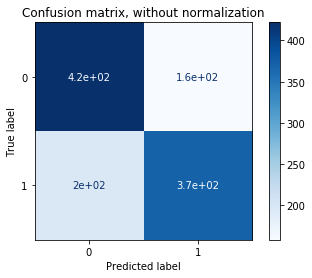

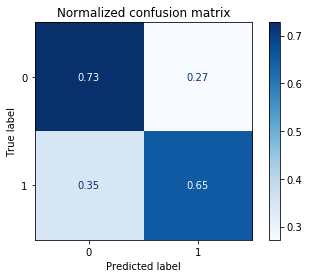

In [174]:
#np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dtr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [175]:
dtr_yhat_prob = dtr.predict_proba(X_test)[:,1]
dtr_yhat = dtr.predict(X_test)

In [176]:
dtr_ytest = dtr.predict(test_df)

## Logistic Regression

In [177]:
from sklearn.linear_model import LogisticRegression

In [178]:
lr_params = {'C': np.logspace(start=-5, stop=3, num=100)}
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X_train, y_train)

In [179]:
logreg = LogisticRegression()

In [180]:
lr = GridSearchCV(logreg, lr_params, scoring='neg_log_loss', refit=True, cv = splits)

In [181]:
lr.fit(X_train,y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x1308cdad0>,
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=N...
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       

Confusion matrix, without normalization
[[419 161]
 [191 377]]
Normalized confusion matrix
[[0.72241379 0.27758621]
 [0.33626761 0.66373239]]


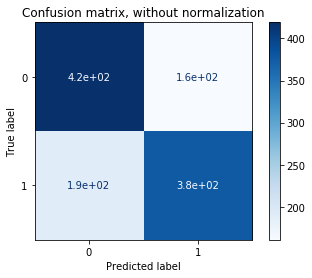

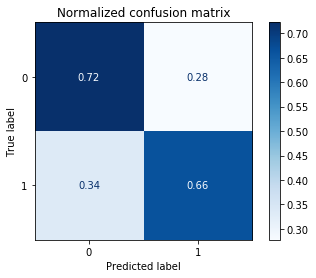

In [182]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [183]:
lr.score(X_test,y_test)

-0.5835424683307019

In [184]:
lr_yhat_prob = lr.predict_proba(X_test)[:,1]
lr_yhat = lr.predict(X_test)

In [185]:
lr_ytest = lr.predict(test_df)

## AdaBoost Regressor

In [186]:
from sklearn.ensemble import AdaBoostClassifier

In [187]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X_train, y_train)


ada_params = {
    'n_estimators': [400,500,600],
    'learning_rate' : [0.01,0.1,0.8,1.0,1.2],
}

In [188]:
ada = AdaBoostClassifier()

In [189]:
adr = GridSearchCV(ada, ada_params, scoring='neg_log_loss', refit=True, cv = splits)

In [190]:
adr.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x1325a4850>,
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 0.8, 1.0, 1.2],
                         'n_estimators': [400, 500, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

Confusion matrix, without normalization
[[419 161]
 [188 380]]
Normalized confusion matrix
[[0.72241379 0.27758621]
 [0.33098592 0.66901408]]


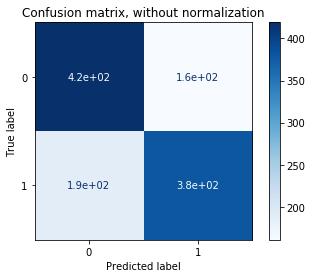

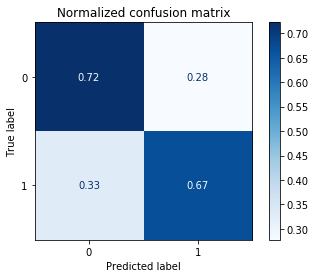

In [191]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(adr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [192]:
adr.score(X_test,y_test)

-0.6515459217215842

In [193]:
adr_yhat_prob = adr.predict_proba(X_test)[:,1]
adr_yhat = adr.predict(X_test)

In [194]:
adr_ytest=adr.predict(test_df)

## Random Forest

In [195]:
from sklearn.ensemble import RandomForestClassifier

In [196]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X_train, y_train)

rf_params = {
    'n_estimators': [400,600], 
     #'max_features': [0.2,0.4,0,8],
    'max_depth': [4,8],
    'min_samples_leaf': [2,4]
}

In [197]:
rf = RandomForestClassifier(n_jobs=-1,warm_start= True,verbose=0,max_features='sqrt')

In [198]:
rf_search = GridSearchCV(rf, rf_params, scoring='neg_log_loss', refit=True, cv = splits)

In [199]:
rf_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x132659bd0>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_scor

Confusion matrix, without normalization
[[419 161]
 [189 379]]
Normalized confusion matrix
[[0.72241379 0.27758621]
 [0.33274648 0.66725352]]


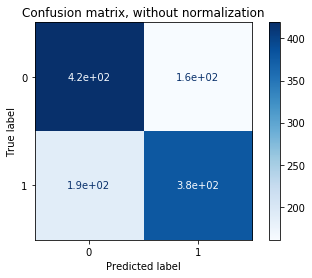

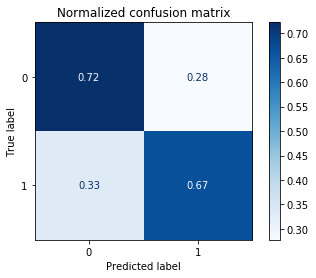

In [200]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf_search, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [201]:
rf_search.score(X_test,y_test)

-0.5910650587166729

In [202]:
rf_yhat_prob = rf_search.predict_proba(X_test)[:,1]
rf_yhat = rf_search.predict(X_test)

In [203]:
rf_ytest = rf_search.predict(test_df)

# Interpret Results

#### Feature importances generated from the different regressors

In [204]:
dtr_feature = dtr.best_estimator_.feature_importances_
lr_feature = lr.best_estimator_.coef_
adr_feature = adr.best_estimator_.feature_importances_
rf_search_feature = rf_search.best_estimator_.feature_importances_

In [205]:
dtr_features = [x for x in dtr_feature]
lr_features = [x for x in lr_feature[0]]
adr_features = [x for x in adr_feature]
rf_search_features = [x for x in rf_search_feature]

On affiche ça dans un dataframe pour que ce soit plus lisible

In [206]:
cols = X_train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Decision Tree feature importances': dtr_features,
     'Logistic Regression feature importances': lr_features,
      'AdaBoost feature importances': adr_features,
    'Random Forest feature importances': rf_search_features
    })

In [207]:
feature_dataframe

,features,Decision Tree feature importances,Logistic Regression feature importances,AdaBoost feature importances,Random Forest feature importances
0,SeedT1,0.077375,0.063997,0.180,0.245573
1,SeedT2,0.034884,-0.058424,0.125,0.184947
2,Seed_diff,0.884428,0.122422,0.695,0.552020
3,W1,0.000116,-0.001969,0.000,0.001788
4,X1,0.000856,-0.006034,0.000,0.002237
5,Z1,0.000000,0.006423,0.000,0.002257
6,Y1,0.000000,0.001564,0.000,0.001924
7,W2,0.001863,0.014357,0.000,0.002758
8,X2,0.000000,-0.017073,0.000,0.003117
9,Z2,0.000000,0.000568,0.000,0.001710


## Second-Level Predictions from the First-level Output

In [208]:
base_predictions_train = pd.DataFrame( {'DecisionTreeClassifier': dtr.predict(X_train).ravel(),
     'LogisticRegression': lr.predict(X_train).ravel(),
     'AdaBoost': adr.predict(X_train).ravel(),
      'RandomForest': rf_search.predict(X_train).ravel()
    })
base_predictions_train.head()


,DecisionTreeClassifier,LogisticRegression,AdaBoost,RandomForest
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [209]:
!pip install plotly

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [210]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [211]:
x_train = np.concatenate(( dtr.predict(X_train).reshape(-1,1), lr.predict(X_train).reshape(-1,1), 
                          adr.predict(X_train).reshape(-1,1), rf_search.predict(X_train).reshape(-1,1)), axis=1)
x_test = np.concatenate(( dtr_yhat.reshape(-1,1), lr_yhat.reshape(-1,1),
                         adr_yhat.reshape(-1,1), rf_yhat.reshape(-1,1)), axis=1)

In [212]:
df_train = pd.DataFrame()

In [213]:
df_train['DecisionTreeClassifier']=dtr.predict(X_train)
df_train['LogisticRegression']=lr.predict(X_train)
df_train['AdaBoost']=adr.predict(X_train)
df_train['RandomForest']=rf_search.predict(X_train)

In [214]:
x_train = df_train

In [215]:
df_test = pd.DataFrame()

In [216]:
df_test['DecisionTreeClassifier']=dtr_yhat
df_test['LogisticRegression']=lr_yhat
df_test['AdaBoost']=adr_yhat
df_test['RandomForest']=rf_yhat

In [217]:
x_test = df_test

In [218]:
df_test_set = pd.DataFrame()

In [219]:
df_test_set['DecisionTreeClassifier']=dtr_ytest
df_test_set['LogisticRegression']=lr_ytest
df_test_set['AdaBoost']=adr_ytest
df_test_set['RandomForest']=rf_ytest

In [220]:
test_df=df_test_set

## XGBoost 

In [221]:
import xgboost as xgb
from xgboost import XGBRegressor

In [222]:
params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.0003,
              'max_depth': 31,
              'subsample': 1,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight':3,
              'gamma':0.25,
              'n_estimators':5000,
              'verbosity':0
              }

In [223]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
columns = x_train.columns
splits = folds.split(x_train, y_train)

y_preds_xgb = np.zeros(test_df.shape[0])
y_train_xgb = np.zeros(x_train.shape[0])
y_test_xgb = np.zeros(x_test.shape[0])

train_df_set = xgb.DMatrix(x_train)
test_df_set = xgb.DMatrix(x_test)
test_set = xgb.DMatrix(test_df)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train_f, X_valid_f = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
    y_train_f, y_valid_f = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train_f, y_train_f)
    val_set = xgb.DMatrix(X_valid_f, y_valid_f)
    
    clf = xgb.train(params_xgb, train_set, num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], verbose_eval=100)
    
    y_train_xgb += clf.predict(train_df_set) / NFOLDS
    y_preds_xgb += clf.predict(test_set) / NFOLDS
    y_test_xgb  += clf.predict(test_df_set) / NFOLDS
    del X_train_f, X_valid_f, y_train_f, y_valid_f
    gc.collect()


Fold: 1
[0]	train-logloss:0.693102	val-logloss:0.693103
[100]	train-logloss:0.688704	val-logloss:0.688791
[200]	train-logloss:0.684568	val-logloss:0.684733
[300]	train-logloss:0.680668	val-logloss:0.680909
[400]	train-logloss:0.676994	val-logloss:0.677311
[500]	train-logloss:0.673533	val-logloss:0.673918
[600]	train-logloss:0.670272	val-logloss:0.670725
[700]	train-logloss:0.667188	val-logloss:0.667709
[800]	train-logloss:0.664289	val-logloss:0.664876
[900]	train-logloss:0.661548	val-logloss:0.662199
[1000]	train-logloss:0.658952	val-logloss:0.65967
[1100]	train-logloss:0.6565	val-logloss:0.657287
[1200]	train-logloss:0.654201	val-logloss:0.655041
[1300]	train-logloss:0.652022	val-logloss:0.652921
[1400]	train-logloss:0.649965	val-logloss:0.650923
[1500]	train-logloss:0.648032	val-logloss:0.649037
[1600]	train-logloss:0.646188	val-logloss:0.647256
[1700]	train-logloss:0.64446	val-logloss:0.645577
[1800]	train-logloss:0.642834	val-logloss:0.643995
[1900]	train-logloss:0.64128	val-loglos

[900]	train-logloss:0.660567	val-logloss:0.666841
[1000]	train-logloss:0.657894	val-logloss:0.66477
[1100]	train-logloss:0.655371	val-logloss:0.662838
[1200]	train-logloss:0.652993	val-logloss:0.661033
[1300]	train-logloss:0.650747	val-logloss:0.659344
[1400]	train-logloss:0.648631	val-logloss:0.657771
[1500]	train-logloss:0.646626	val-logloss:0.656299
[1600]	train-logloss:0.644738	val-logloss:0.654921
[1700]	train-logloss:0.642955	val-logloss:0.653635
[1800]	train-logloss:0.641273	val-logloss:0.652437
[1900]	train-logloss:0.639678	val-logloss:0.651316
[2000]	train-logloss:0.638168	val-logloss:0.65027
[2100]	train-logloss:0.63675	val-logloss:0.649297
[2200]	train-logloss:0.635401	val-logloss:0.648389
[2300]	train-logloss:0.634137	val-logloss:0.647539
[2400]	train-logloss:0.632932	val-logloss:0.646755
[2500]	train-logloss:0.631795	val-logloss:0.646024
[2600]	train-logloss:0.630732	val-logloss:0.645348
[2700]	train-logloss:0.629716	val-logloss:0.644717
[2800]	train-logloss:0.628764	val-l

[1800]	train-logloss:0.642266	val-logloss:0.647148
[1900]	train-logloss:0.640708	val-logloss:0.645793
[2000]	train-logloss:0.639231	val-logloss:0.644519
[2100]	train-logloss:0.637836	val-logloss:0.643322
[2200]	train-logloss:0.63652	val-logloss:0.642197
[2300]	train-logloss:0.635277	val-logloss:0.641136
[2400]	train-logloss:0.634103	val-logloss:0.640145
[2500]	train-logloss:0.632994	val-logloss:0.639211
[2600]	train-logloss:0.63195	val-logloss:0.638337
[2700]	train-logloss:0.630959	val-logloss:0.637514
[2800]	train-logloss:0.630025	val-logloss:0.636742
[2900]	train-logloss:0.629137	val-logloss:0.636018
[3000]	train-logloss:0.628309	val-logloss:0.63534
[3100]	train-logloss:0.627524	val-logloss:0.634707
[3200]	train-logloss:0.62678	val-logloss:0.634118
[3300]	train-logloss:0.626073	val-logloss:0.633566
[3400]	train-logloss:0.625413	val-logloss:0.633049
[3500]	train-logloss:0.624783	val-logloss:0.632565
[3600]	train-logloss:0.624192	val-logloss:0.632109
[3700]	train-logloss:0.623628	val-l

[2700]	train-logloss:0.633628	val-logloss:0.62171
[2800]	train-logloss:0.632734	val-logloss:0.620526
[2900]	train-logloss:0.631893	val-logloss:0.619401
[3000]	train-logloss:0.631092	val-logloss:0.618331
[3100]	train-logloss:0.630343	val-logloss:0.617311
[3200]	train-logloss:0.629624	val-logloss:0.61634
[3300]	train-logloss:0.628955	val-logloss:0.615419
[3400]	train-logloss:0.628318	val-logloss:0.614539
[3500]	train-logloss:0.627713	val-logloss:0.613703
[3600]	train-logloss:0.62715	val-logloss:0.612905
[3700]	train-logloss:0.626609	val-logloss:0.612146
[3800]	train-logloss:0.626103	val-logloss:0.611424
[3900]	train-logloss:0.625624	val-logloss:0.610734
[4000]	train-logloss:0.625176	val-logloss:0.610079
[4100]	train-logloss:0.62475	val-logloss:0.609452
[4200]	train-logloss:0.624347	val-logloss:0.608856
[4300]	train-logloss:0.623972	val-logloss:0.608288
[4400]	train-logloss:0.623609	val-logloss:0.607746
[4500]	train-logloss:0.623268	val-logloss:0.607231
[4600]	train-logloss:0.622952	val-l

In [224]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, title, figsize=(7,6)):
    y_pred = y_pred.round().astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Current'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

/Users/mathispotel/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



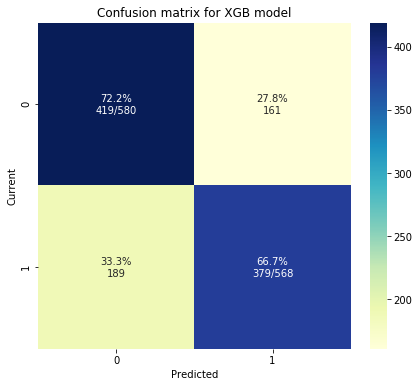

In [225]:
plot_cm(y_test, y_test_xgb, 'Confusion matrix for XGB model')

# Submission File

In [226]:
sub_file = pd.read_csv('Data/MSampleSubmissionStage1_2020.csv')

In [227]:
sub_file['Pred']=y_preds_xgb

In [228]:
sub_file.head()

,ID,Pred
0,2015_1107_1112,0.653201
1,2015_1107_1116,0.653201
2,2015_1107_1124,0.653201
3,2015_1107_1125,0.351049
4,2015_1107_1129,0.653201


In [238]:
sub_file.to_csv("submission_file.csv",index=False)

In [231]:
!pip install kaggle

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 58 kB 343 kB/s eta 0:00:01
     |████████████████████████████████| 118 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 384 kB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=8f7b6d270eb8caab6dea2fd8833d8afc1df6b98241b682d1ccb511b2668d843d
  Stored in directory: /Users/mathispotel/Library/Caches/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=5487 sha256=989ad0855cf764f997b01b4dda2c4ef6c184788dc1d6fdd3a49de2eac7dbaeb0
  Stored in directory: /Users/mathispotel/Library/Caches/pip/wheels/7c/26/30/5f3d95da00fe94d0c4a5ec5b4ffd2e1ae18545f5fa61752e52
Successfully built kaggle python-slugi

In [236]:
!mv kaggle.json ~/.kaggle/kaggle.json

In [239]:
!kaggle competitions submit -c google-cloud-ncaa-march-madness-2020-division-1-mens-tournament -f submission_file.csv -m "First submission Hackaton"

100%|████████████████████████████████████████| 378k/378k [00:07<00:00, 54.5kB/s]
Successfully submitted to Google Cloud & NCAA® ML Competition 2020-NCAAM